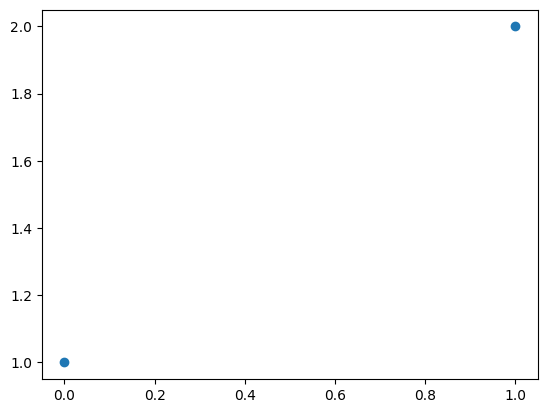

In [1]:
import sys
sys.path.append('f:/seismic/code/core')
sys.path.append('/seismic/code/core')
sys.path.append('/kaggle/input/my-seis-library/')
import kaggle_support as kgs
import importlib
import numpy as np
import matplotlib.pyplot as plt
import glob
import copy
import os
import seis_forward
import seis_test
import seis_invert
import seis_prior
import seis_nn
import cupy as cp
plt.scatter([0,1],[1,2])
#fls.download_kaggle_dataset('jeroencottaar/byu-many-models-2/', fls.result_dir + '/many_full_res/')

In [40]:
import scipy.optimize as opt
import inspect

print(inspect.signature(opt.fmin_l_bfgs_b))
print(inspect.signature(opt.minimize))
opt.fmin_l_bfgs_b?

(func, x0, fprime=None, args=(), approx_grad=0, bounds=None, m=10, factr=10000000.0, pgtol=1e-05, epsilon=1e-08, iprint=-1, maxfun=15000, maxiter=15000, disp=None, callback=None, maxls=20)
(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)


Signature:
opt.fmin_l_bfgs_b(
    func,
    x0,
    fprime=None,
    args=(),
    approx_grad=0,
    bounds=None,
    m=10,
    factr=10000000.0,
    pgtol=1e-05,
    epsilon=1e-08,
    iprint=-1,
    maxfun=15000,
    maxiter=15000,
    disp=None,
    callback=None,
    maxls=20,
)
Docstring:
Minimize a function func using the L-BFGS-B algorithm.

Parameters
----------
func : callable f(x,*args)
    Function to minimize.
x0 : ndarray
    Initial guess.
fprime : callable fprime(x,*args), optional
    The gradient of `func`. If None, then `func` returns the function
    value and the gradient (``f, g = func(x, *args)``), unless
    `approx_grad` is True in which case `func` returns only ``f``.
args : sequence, optional
    Arguments to pass to `func` and `fprime`.
approx_grad : bool, optional
    Whether to approximate the gradient numerically (in which case
    `func` returns only the function value).
bounds : list, optional
    ``(min, max)`` pairs for each element in ``x``, defining


10000
FlatVel_B


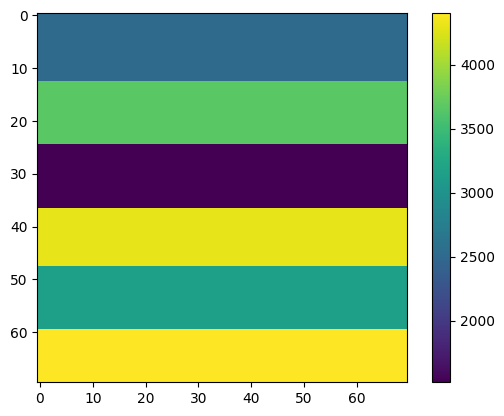

In [ ]:
importlib.reload(kgs)
data=kgs.load_all_train_data()
print(len(data))
for d in data:
    d.check_constraints()
d = data[7011]
print(d.family)
d.load_to_memory()
plt.figure()
plt.imshow(cp.asnumpy(d.velocity.data));plt.colorbar();#plt.clim([-3,3])

In [16]:
# TODO: tune lambda, tune convergence criteria, tune L vs full, velB
seis_correct = seis_forward.vel_to_seis(d.velocity, d.seismogram)[0]
d_guess = seis_nn.make_default_pretrained().infer([d])[0]
d_guess.velocity_guess.data = cp.array(d_guess.velocity_guess.data)
d_guess.velocity_guess.min_vel = cp.array(d_guess.velocity_guess.min_vel)
# offset_vector = cp.array(1e1*np.random.default_rng(seed=0).normal(0,1,size=d.velocity.to_vector().shape), dtype=kgs.base_type_gpu)
# velocity_offset = copy.deepcopy(d.velocity)
# velocity_offset.from_vector(velocity_offset.to_vector() + offset_vector)
# prior = seis_prior.RowTotalVariation(λ=1e-20)
# basis_functions = prior.basis_functions()
#print(seis_invert.cost_and_gradient(cp.linalg.solve(basis_functions.T@basis_functions, basis_functions.T@(d.velocity.to_vector())), seis_correct.to_vector(), prior, basis_functions))
#print(seis_invert.cost_and_gradient(cp.linalg.solve(basis_functions.T@basis_functions, basis_functions.T@(velocity_offset.to_vector())), seis_correct.to_vector(), prior, basis_functions))
#print('base RMS', kgs.rms(cp.asnumpy(cp.mean(velocity_offset.data - d.velocity.data,axis=0)[:,None] + 0*d.velocity.data)))
#print('base seis diff', kgs.rms(cp.asnumpy(seis_correct.to_vector() - seis_forward.vel_to_seis(velocity_offset, seis_correct)[0].to_vector())))

F:/seismic/models/brendan/*.pth
Loading:  F:/seismic/models/brendan\bartley_unet2d_convnext_seed1_epochbest_FT.pth
Replacing all activations with GELU...
Replacing all norms with InstanceNorm...
Replacing forward functions...
Loading:  F:/seismic/models/brendan\bartley_unet2d_convnext_seed2_epochbest_FT.pth
Replacing all activations with GELU...
Replacing all norms with InstanceNorm...
Replacing forward functions...
n_models: 2


In [18]:
importlib.reload(seis_invert)
λ_vals = 10**np.linspace(-11,-6,6)
#λ_vals = [10**-9]
maxiter=1000
res = [[],[],[]]
rms_vals = [[],[],[]]
cost_vals = [[],[],[]]
res_vals = [[],[],[]]

In [19]:
NN=3
for λ in λ_vals:    
    prior = seis_prior.RowTotalVariation(λ=1e-8)
    prior.epsilon = 0.1
    basis_functions = prior.basis_functions()
    #seis_invert.true_vel = d.velocity
    res[0].append(seis_invert.seis_to_vel(seis_correct, d.velocity, prior, maxiter=maxiter))
    print('done1', λ)
    res[1].append(seis_invert.seis_to_vel(d.seismogram, d.velocity, prior,maxiter=maxiter))
    print('done2', λ)
    res[2].append(seis_invert.seis_to_vel(d.seismogram, d_guess.velocity_guess, prior,maxiter=maxiter))
    print('done2', λ)
    for ii in range(NN):
        rms_vals[ii].append(cp.asnumpy(kgs.rms(res[ii][-1].to_vector()-d.velocity.to_vector())))
        cost_vals[ii].append( cp.asnumpy(
            seis_invert.cost_and_gradient(cp.linalg.solve(basis_functions.T@basis_functions, basis_functions.T@(res[ii][-1].to_vector())), seis_correct.to_vector(), prior, basis_functions) ))
        res_vals[ii].append(cp.asnumpy(kgs.rms( kgs.rms( seis_correct.data - seis_forward.vel_to_seis(res[ii][-1], d.seismogram)[0].data ) )))
    print('RMS', λ, rms_vals[0], rms_vals[1], rms_vals[2])
    print('Cost', λ, cost_vals[0], cost_vals[1], cost_vals[2])
    print('res', λ, res_vals[0], res_vals[1], res_vals[2])

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 12.297358306353615
        x: [ 2.514e+03  2.514e+03 ...  4.405e+03  1.520e+03]
      nit: 74
      jac: [ 2.110e-06 -8.596e-07 ...  2.277e-06  7.182e-06]
 hess_inv: [[ 7.899e-05 -2.004e-04 ...  1.007e-04 -1.519e-03]
            [-2.004e-04  3.375e-02 ...  1.001e-02  7.974e-02]
            ...
            [ 1.007e-04  1.001e-02 ...  4.552e-01  4.356e-01]
            [-1.519e-03  7.974e-02 ...  4.356e-01  2.762e+00]]
     nfev: 77
     njev: 77
done1 1e-11
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 14.580220416650425
        x: [ 2.514e+03  2.514e+03 ...  4.405e+03  1.520e+03]
      nit: 152
      jac: [ 3.024e-07  1.646e-05 ... -1.410e-06 -1.655e-06]
 hess_inv: [[ 8.113e-05 -1.766e-04 ...  1.031e-03 -4.591e-03]
            [-1.766e-04  4.215e-02 ... -9.128e-03  7.245e-03]
            ...
            [ 1.031e-03 -9.128e-03 ...  2

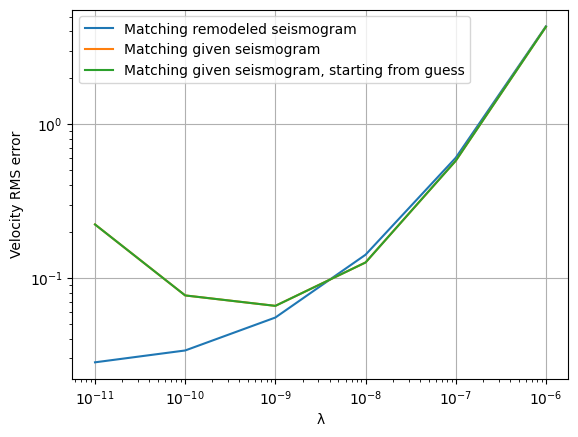

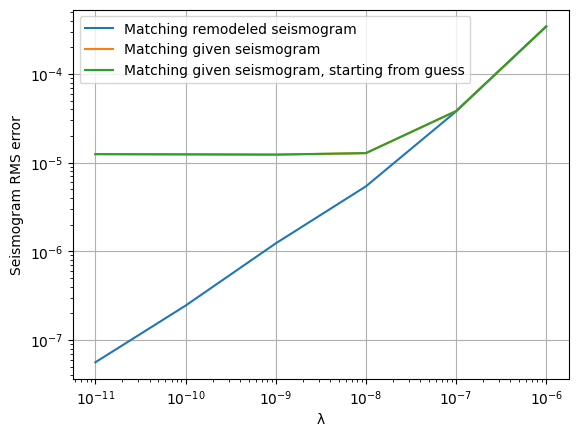

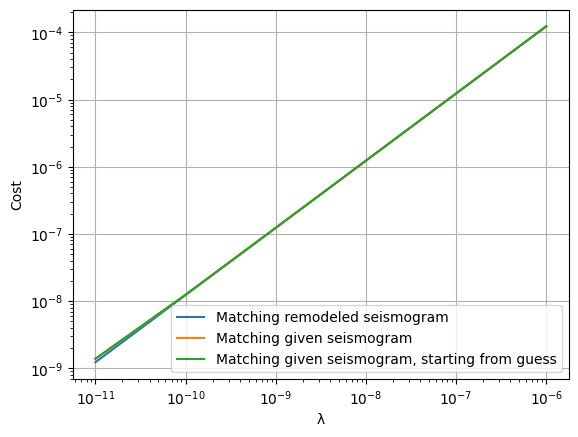

In [21]:
for to_plot in [[rms_vals, 'Velocity RMS error'], [res_vals, 'Seismogram RMS error'], [cost_vals, 'Cost']]:
    plt.figure()
    plt.loglog(λ_vals, to_plot[0][0])
    plt.loglog(λ_vals, to_plot[0][1])
    plt.loglog(λ_vals, to_plot[0][2])
    plt.xlabel('λ')
    plt.ylabel(to_plot[1])
    plt.grid(True)
    plt.legend(('Matching remodeled seismogram', 'Matching given seismogram', 'Matching given seismogram, starting from guess'))

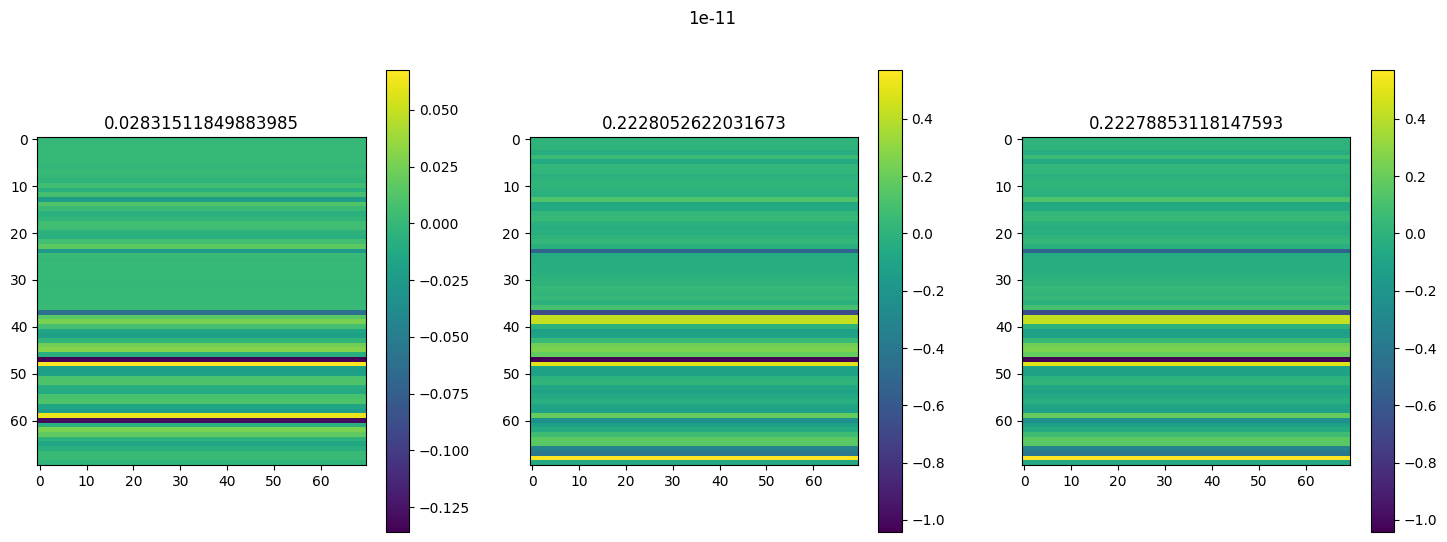

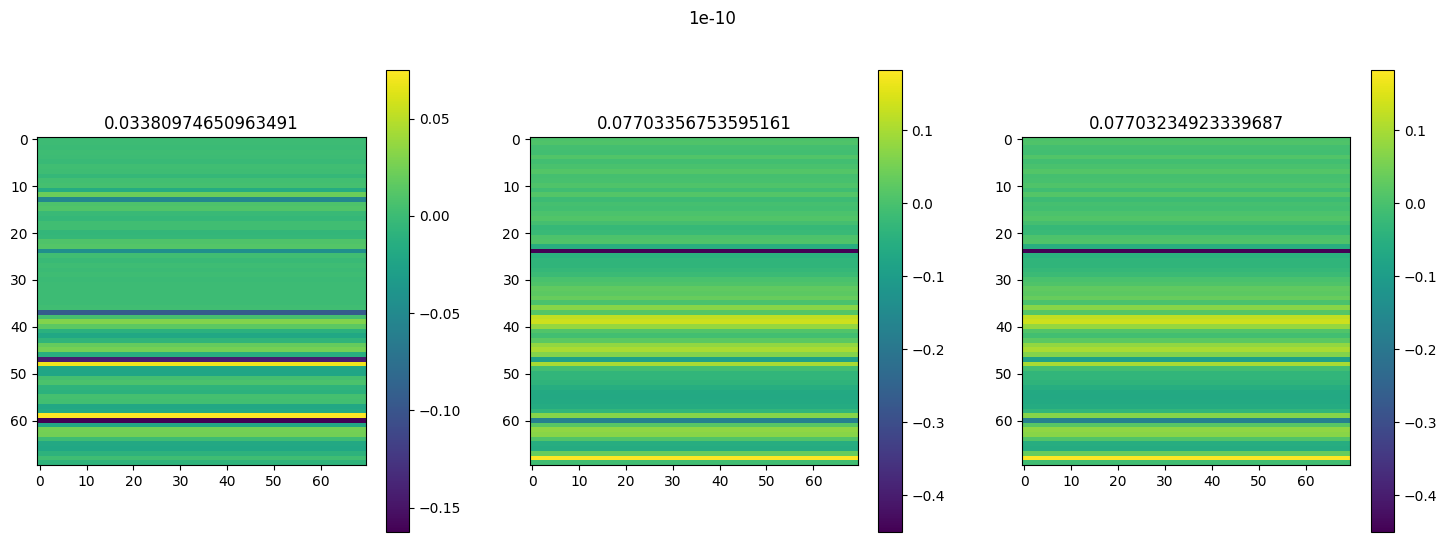

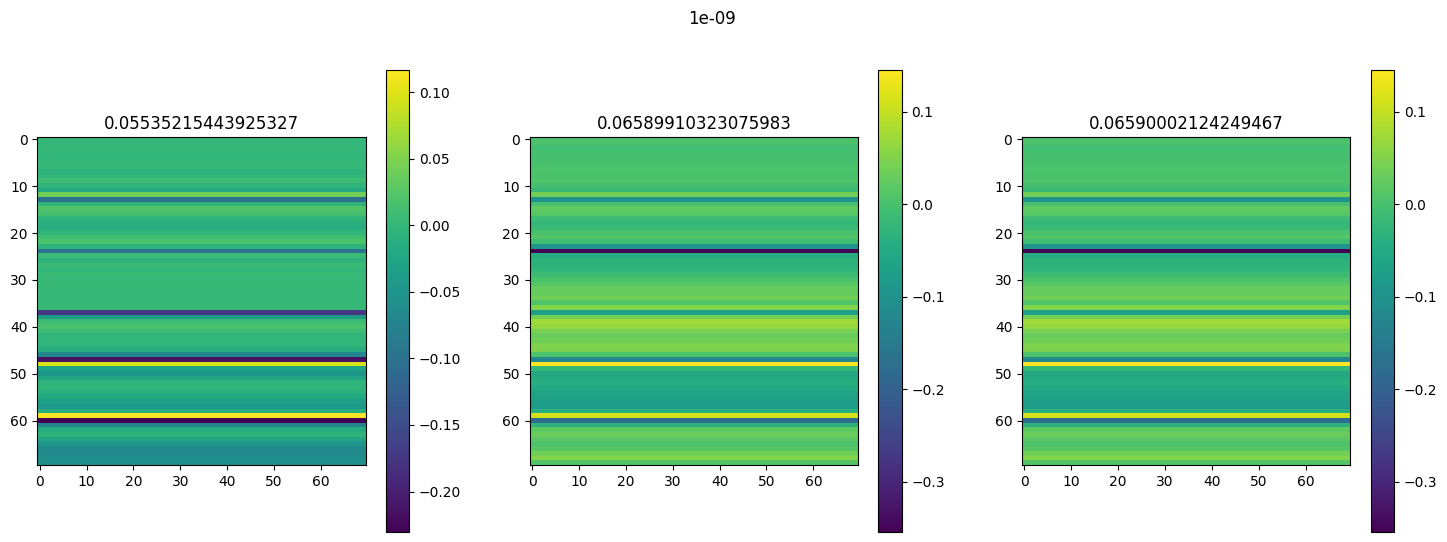

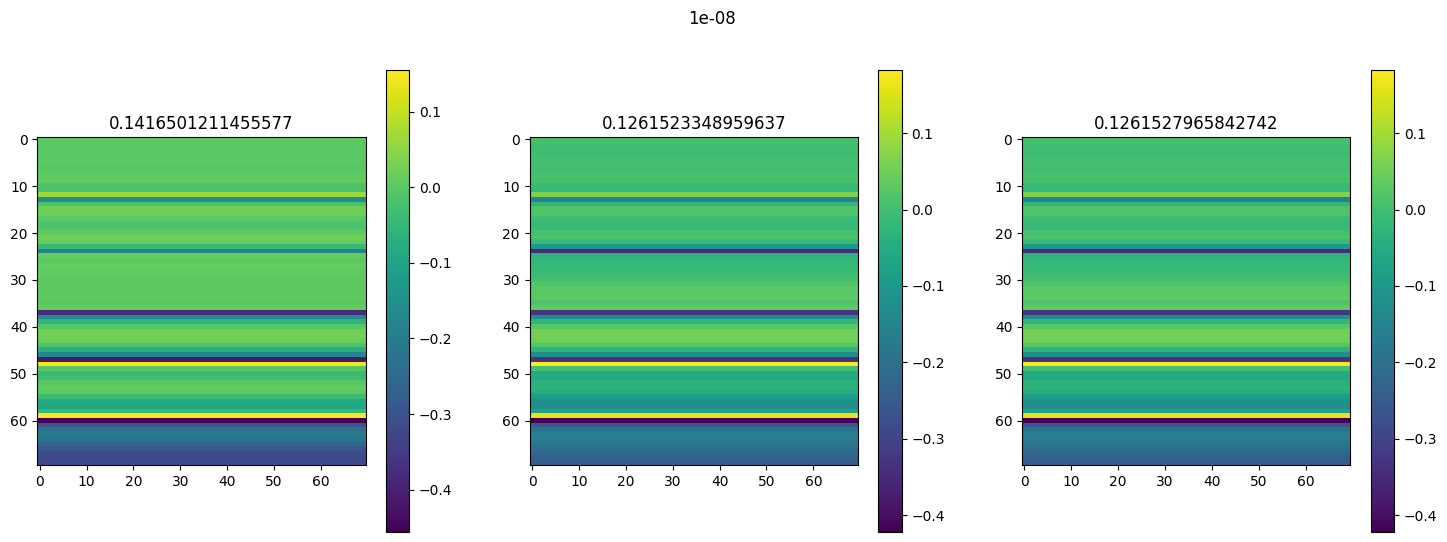

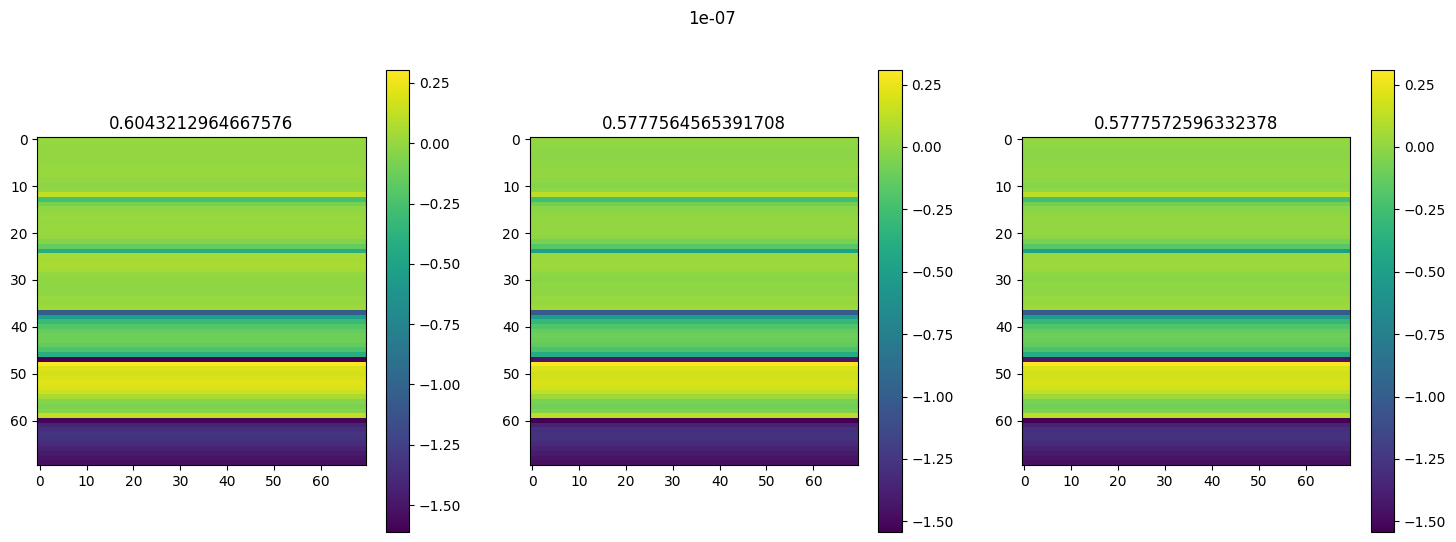

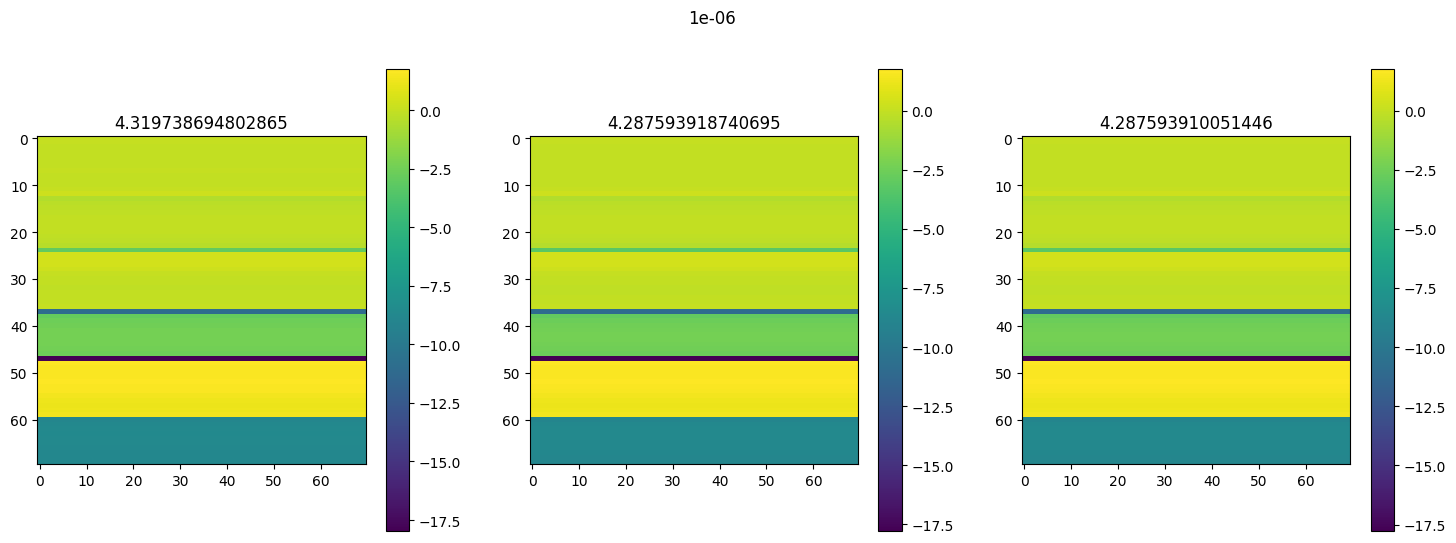

In [22]:
#plt.figure()
#plt.imshow( cp.asnumpy(velocity_offset.data - d.velocity.data));plt.colorbar()
#plt.figure()
#plt.imshow( cp.asnumpy(cp.mean(velocity_offset.data - d.velocity.data,axis=0)[:,None] + 0*d.velocity.data));plt.colorbar()
#plt.title(kgs.rms (cp.mean(velocity_offset.data - d.velocity.data,axis=0)[:,None] + 0*d.velocity.data))
for i,λ in enumerate(λ_vals): 
    _,ax=plt.subplots(1,NN,figsize=(6*NN,6))
    for ii in range(NN):
        plt.sca(ax[ii])
        plt.imshow( cp.asnumpy(res[ii][i].data - d.velocity.data));plt.colorbar()
        plt.title(rms_vals[ii][i])
    plt.suptitle(λ)

In [23]:
rms_vals

[[array(0.02831512),
  array(0.03380975),
  array(0.05535215),
  array(0.14165012),
  array(0.6043213),
  array(4.31973869)],
 [array(0.22280526),
  array(0.07703357),
  array(0.0658991),
  array(0.12615233),
  array(0.57775646),
  array(4.28759392)],
 [array(0.22278853),
  array(0.07703235),
  array(0.06590002),
  array(0.1261528),
  array(0.57775726),
  array(4.28759391)]]

In [24]:
cost_vals

[[array(1.22973583e-09),
  array(1.22972659e-08),
  array(1.22970252e-07),
  array(1.22965607e-06),
  array(1.2295e-05),
  array(0.00012284)],
 [array(1.38597347e-09),
  array(1.24520682e-08),
  array(1.23123037e-07),
  array(1.22980397e-06),
  array(1.22951386e-05),
  array(0.00012284)],
 [array(1.38597342e-09),
  array(1.2452068e-08),
  array(1.23123037e-07),
  array(1.22980397e-06),
  array(1.22951386e-05),
  array(0.00012284)]]

In [25]:
res_vals

[[array(5.62487652e-08),
  array(2.44803001e-07),
  array(1.23074716e-06),
  array(5.40905263e-06),
  array(3.77735979e-05),
  array(0.00034427)],
 [array(1.24786946e-05),
  array(1.24158015e-05),
  array(1.23356943e-05),
  array(1.28125604e-05),
  array(3.81431368e-05),
  array(0.00034317)],
 [array(1.24786844e-05),
  array(1.24157996e-05),
  array(1.23356999e-05),
  array(1.2812587e-05),
  array(3.81431435e-05),
  array(0.00034317)]]

In [26]:
λ_vals = [-13]

In [27]:
NN=2